# Lecture 5 - Modelling and Analysis Using DynamicalSystems.jl

- [DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/latest/) is a comprehensive package providing a wide range of utilities for working with dynamical systems and investigating chaos in Julia.


## Contents
1. [The DynamicalSystems.jl Interface](#interface)
2. [Trajectories](#trajectories)
3. [Pre-Defined Dynamical Systems](#pre-defined)
4. [Orbit Diagrams](#orbits)
5. [Lyapunov Exponents](#lyapunov)
6. [Interactive Plotting](#plotting)
7. [Further Reading](#further-reading)
8. [Next Week](#next-week)

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("DynamicalSystems")
Pkg.add("OrdinaryDiffEq")  # Component package of DifferentialEquations.jl for solving ODEs
Pkg.add("CairoMakie")      # Alternative to Plots.jl
Pkg.add("Printf")          # C style string formatting

In [2]:
using DynamicalSystems, CairoMakie

## 1. The DynamicalSystems.jl Interface <a class="anchor" id="types"></a>


- As you know, a dynamical system can be either continuous in time, 

$$\frac{du}{dt} = f(u, p, t),$$

or discrete (a map),

$$u_{n+1} = f(u_n, p, n),$$

where $u \in \mathbb{R}^n$ is the state of the system, $p \in \mathbb{R}^m$ are the parameters of the system, and the function $f:\mathbb{R}^n \to \mathbb{R}^n$ is the "dynamic rule" describing the equations of motion of the dynamical system.


- Given some system, continuous or discrete, with dynamic rule $f$, DynamicalSystems.jl implements the abstract data type `DynamicalSystem` to describe such a system.


- The Julia function `f` implementing the dynamic rule $f$ may be defined either **in-place** or **out-of-place**. 

### 1.1. Out-of-place (OOP) Dynamic Rule


- Out-of-place `f` is more efficient for **small systems** and requires a function signature of the form 

    ```f(u, p, t) -> SVector``` 
    
where `SVector` is a static array type from the [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl) library.  


#### Example 1: Hénon Map (Discrete, Out-of-Place)

- The [Hénon Map](https://en.wikipedia.org/wiki/H%C3%A9non_map) is a classic discrete-time dynamical system which exhibits chaotic behaviour. It was developed as a simplified discrete-time analogue of the Lorenz system.

$$\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}$$

In [3]:
function f_henon(u, p, t)
    xₙ, yₙ = u
    a, b = p
    return SVector{2}(1 - a * xₙ^2 + yₙ, b * xₙ)
end

f_henon (generic function with 1 method)

In [4]:
u = rand(2)
p = [1.4, 0.3]
henon = DiscreteDynamicalSystem(f_henon, u, p)

2-dimensional discrete dynamical system
 state:       [0.781596, 0.268918]
 rule f:      f_henon
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.4, 0.3]

In [24]:
DiscreteDynamicalSystem <: DynamicalSystem

true

### 1.2. In-place (IIP) Dynamic Rule

- In-place `f` is more efficient for **large systems** and requires a function signature of the form

    `f!(du, u, p, t) -> nothing`
    
    
- Typically, the in-place formulation begins to outperform the out-of-place formulation around $n = 10$.


#### Example 2: Lorenz System (Continous, In-Place)

- The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system), which you saw in the first part of today's lecture, has the equations of motion

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z 
\end{aligned}
$$

In [25]:
function f_lorenz63!(du, u, p, t)
    x, y, z = u
    σ, ρ, β = p
    du[1] = σ * (y - x)
    du[2] = x * (ρ - z) - y
    du[3] = x * y - β * z
    return nothing
end

f_lorenz63! (generic function with 1 method)

In [26]:
lorenz63 = ContinuousDynamicalSystem(f_lorenz63!, rand(3), [10.0, 28.0, 8/3])

3-dimensional continuous dynamical system
 state:       [0.144024, 0.498242, 0.39894]
 rule f:      f_lorenz63!
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [10.0, 28.0, 2.66667]

- As you can see, the specific constructor you need to use depends on whether your system is a `DiscreteDynamicalSystem` or a `ContinuousDynamicalSystem` (both of which are subtypes of `DynamicalSystem`).


- The constructors will automatically detect from the function signature whether you have provided an in-place or out-of-place method for the dynamic rule.

## 2. Trajectories <a class="anchor" id="trajectories"></a>

- Given an instance of a (concrete subtype of) `DynamicalSystem`, it is then incredibly straightforward to compute trajectories with the `trajectory` function.

In [27]:
trajectory(henon, 10)  # Integrate the discrete system for 10 iterations

2-dimensional Dataset{Float64} with 11 points
     0.105647        0.509352
     1.49373         0.031694
    -2.09201         0.448118
    -4.67901        -0.627604
   -30.278          -1.4037
 -1283.87           -9.08341
    -2.30764e6    -385.16
    -7.4553e12      -6.92293e5
    -7.78141e25     -2.23659e12
    -8.47704e51     -2.33442e25
    -1.00604e104    -2.54311e51

In [30]:
trajectory(lorenz63, 50, Δt = 0.1)  # Integrate the continuous system for 10 seconds with timesteps of 0.1s

3-dimensional Dataset{Float64} with 501 points
   0.144024     0.498242   0.39894
   0.633333     1.39519    0.336457
   2.06224      4.47579    0.5856
   6.52753     13.8018     3.75385
  16.8412      27.5328    26.2829
  15.3587       0.677142  46.9826
   0.957501    -9.167     32.4679
  -5.07539     -8.2645    26.9232
  -7.2074      -8.7701    25.2952
  -8.61075     -9.85669   25.9296
  -9.49101     -9.8643    27.8901
  -9.22591     -8.3841    28.9708
  -8.15163     -7.06324   27.9978
   ⋮                      
   0.361234    -1.03775   21.2717
  -0.502796    -1.09897   16.3065
  -1.18396     -2.08525   12.6056
  -2.61699     -4.79366   10.2106
  -6.14526    -11.3973    10.8694
 -13.1935     -20.9383    22.9015
 -15.5112      -9.77432   41.4775
  -6.07055      3.10246   33.9297
   0.0281228    3.49567   25.245
   2.30128      3.98328   19.7719
   4.23514      6.72229   16.6607
   7.72996     12.3249    17.7703

- As we mentioned earlier, DynamicalSystems.jl uses the ODE solvers from DifferentialEquations.jl "under the hood" to integrate trajectories of continuous dynamical systems.


- By default, the `SimpleATsit5()` solver is used with `abstol` and `reltol` equal to `1e-6`. 


- For more control over the ODE solver, use the `diffeq` keyword argument with a [named tuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) of arguments for the solver.

In [31]:
using OrdinaryDiffEq  # Need to import this if we want to specify a solver algorithm

trajectory(
    lorenz63, 
    50, 
    Δt = 0.1, 
    diffeq = (alg = Vern9(), abstol = 1e-12, reltol = 1e-12),
)

3-dimensional Dataset{Float64} with 501 points
   0.144024    0.498242    0.39894
   0.633333    1.39519     0.336457
   2.06224     4.47579     0.585601
   6.52753    13.8018      3.75385
  16.8412     27.5328     26.2829
  15.3587      0.677157   46.9826
   0.957509   -9.16699    32.4679
  -5.07538    -8.26449    26.9232
  -7.2074     -8.7701     25.2952
  -8.61075    -9.8567     25.9296
  -9.49102    -9.86431    27.8901
  -9.22592    -8.3841     28.9708
  -8.15163    -7.06323    27.9978
   ⋮                      
  -3.92827    -1.24024    26.0495
  -2.64256    -2.50836    20.4264
  -3.36936    -4.94134    16.5811
  -5.96781    -9.74217    15.659
 -10.8912    -16.4489     22.0573
 -14.113     -13.1077     35.5137
  -9.0233     -2.00632    34.7231
  -3.50336     0.0419107  26.8732
  -1.55563    -0.831723   20.6434
  -1.53525    -2.10059    15.9945
  -2.697      -4.5701     12.8477
  -5.70881   -10.1439     12.5008

- Shadowing theorem

## 3. Pre-Defined Dynamical Systems <a class="anchor" id="pre-defined"></a>

- In fact, DynamicalSystems.jl also provides a huge number of pre-defined dynamical systems, making the process of setting up and integrating trajectories of dynamical systems even easier still.

In [32]:
ds = Systems.lorenz()  # Lorenz system with default parameters

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 rule f:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

In [33]:
trajectory(ds, 10, Δt = 0.1)

3-dimensional Dataset{Float64} with 101 points
  0.0      10.0       0.0
  8.92478  19.6843    6.02839
 20.0553   24.8278   39.9785
  9.89834  -7.67213  42.312
 -2.67297  -9.86486  30.4531
 -6.73013  -8.71064  27.4841
 -7.91     -8.6127   26.6731
 -8.44188  -8.84913  26.7275
 -8.72491  -8.86503  27.1909
 -8.70356  -8.53165  27.5098
 -8.44777  -8.15714  27.3383
 -8.22042  -8.09542  26.8448
 -8.23684  -8.3923   26.4873
  ⋮                  
 -9.02117  -8.73059  28.0281
 -8.50876  -7.87543  27.8401
 -7.9705   -7.61641  26.849
 -7.90031  -8.12215  25.9823
 -8.35258  -8.96853  25.9951
 -8.94423  -9.40349  26.9656
 -9.09671  -8.90393  27.9988
 -8.62374  -7.96528  28.0069
 -8.01075  -7.54849  27.038
 -7.8329   -7.96259  26.0287
 -8.23296  -8.84597  25.8467
 -8.879    -9.44531  26.7382

- With just two lines of code, we can get a trajectory for a wide range of pre-defined dynamical systems!

## 4. Orbit Diagrams <a class="anchor" id="orbits"></a>

- In the first exercise you plotted the famous orbit diagram of the [logistic map](https://en.wikipedia.org/wiki/Logistic_map),

$$x_{n+1} = rx_n(1-x_n).$$


- Let's see how we could do this using the `orbitdiagram` function of DynamicalSystems.jl.

In [34]:
ds = Systems.logistic()  # Logistic map with default parameters

# Params for orbitdiagram function
i = 1                   # Number of variables to save (logistic map only has one variable)
p_index = 1             # Index of the parameter to vary (logistic map only has one parameter)
p_values = 2.8:0.005:4  # Values of the parameter r at which to compute the orbits
n_points = 2000         # Number of points to save for each parameter value
transient_steps = 2000  # Number of transient steps (output is only saved after this many steps have elapsed)

output = orbitdiagram(ds, i, p_index, p_values, n = n_points, Ttr = transient_steps);

In [42]:
j = 200
println("r = $(p_values[j])")
output[j]

r = 3.795


2000-element Vector{Float64}:
 0.5746556721738538
 0.9275986836735649
 0.2548697929098082
 0.7207129340654351
 0.763879613793981
 0.6844948500638502
 0.8195744628881865
 0.5611748573316144
 0.9345477317715829
 0.2321335801421944
 0.676449570322172
 0.8305947589601937
 0.533983464795855
 ⋮
 0.8794059442509827
 0.40246403632734157
 0.9126471623247421
 0.30254620221915757
 0.8007905314305946
 0.6053975882854533
 0.9065926671158002
 0.32136971956586996
 0.8276561909511312
 0.5413241909166473
 0.9422693211750957
 0.20643983144207972

- Even better, let's plot it!

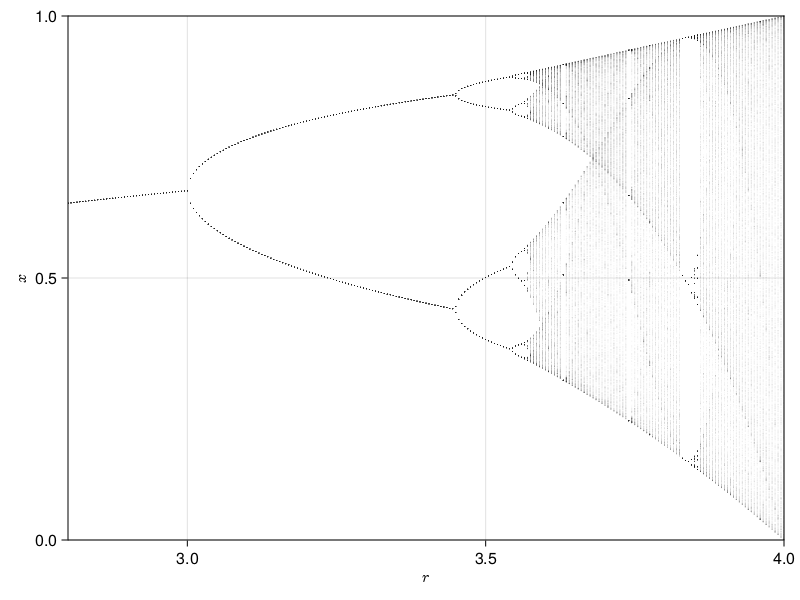

In [43]:
fig = CairoMakie.Figure()
ax = Axis(fig[1, 1], xlabel = L"r", ylabel = L"x")

for j in eachindex(p_values)
    scatter!(
        ax,
        fill(p_values[j], n_points),
        output[j];
        markersize = 0.8, 
        color = ("black", 0.05),
    )
end
xlims!(ax, p_values[1], p_values[end])
ylims!(ax, 0, 1)
fig

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

### 5.1. The Largest Lyapunov Exponent

- You saw earlier that the Lyapunov exponent measures the exponential divergence of trajectories which are initially close together in phase space.


- Consider some state $\mathbf x(t)$ of a chaotic dynamical system. At time $t = 0$ we obtain a nearby state by perturbing the original state $\mathbf x_0$ by a small amount $\mathbf y_0$, such that the nearby state evolves as $\mathbf x(t) + \mathbf y(t)$. The initial distance between the two states is then given by $\delta_0 = ||\mathbf y_0||$.


- The distance between the two trajectories will evolve approximately as

$$\delta(t) \approx \delta_0 \exp (\lambda_1 t),$$

where $\lambda_1$ is the **largest Lyapunov exponent**.

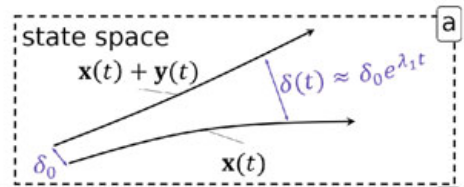
[Source](https://link.springer.com/book/10.1007/978-3-030-91032-7)


- To compute the largest Lyapunov exponent, we could simply integrate this system until $\delta(t)$ reaches some pre-defined upper or lower threshold at time $T$, and estimate the maximum Lyapunov exponent as

$$\lambda_{max} \approx \frac{1}{T} \ln \left( \frac{\delta (T)}{\delta_0} \right).$$


- In practice, this will yield a very noise estimate for $\lambda_{max}$. To obtain a better estimate, every time the separation $\delta(t)$ reaches the upper or lower separation threshold, we can store the time $t_i$ at which this happens and then rescale the perturbed trajectory back to the initial separation $\delta_0$, before repeating the procedure. 


- Our improved estimate for the largest Lyapunov exponent is then

$$\lambda_{max} \approx \frac{1}{t_n - t_0} \sum_{i = 1}^{n} \ln \left( \frac{\delta (t_i)}{\delta_0} \right).$$



- DynamicalSystems.jl implements this routine using the `lyapunov` function.

- Lyapunov time: $\tau = 1 / \lambda_{max}$

$$\delta(t) \approx \delta_0 \exp (t / \tau)$$

In [8]:
# Maximum Lyapunov exponent of the Hénon map we defined earlier
lyapunov(henon, 10000)  

0.4192063220241391

In [11]:
# Maximum Lyapunov exponent of the Lorenz system we defined earlier
lorenz = Systems.lorenz()
lyapunov(lorenz, 10000) 

0.9038192878245636

In [12]:
using Printf
@time for i in 1:6
    T = 10^i
    λ = lyapunov(lorenz, T)
    @printf "T = %7is, λ = %f \n" T λ
end

T =      10s, λ = -0.049779 
T =     100s, λ = 0.700237 
T =    1000s, λ = 0.894269 
T =   10000s, λ = 0.903819 
T =  100000s, λ = 0.905040 
T = 1000000s, λ = 0.905486 
 12.305290 seconds (265.73 k allocations: 13.249 MiB, 1.15% compilation time: 28% of which was recompilation)


### 5.2. The Lyapunov Spectrum

- More generally, for an $n$-dimensional system, we can compute $n$ Lyapunov exponents. These exponents are known collectively as the **Lyapunov spectrum**, and are usually given in decreasing order, 

$$\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_n.$$


- Instead of considering a single perturbation to the initial state $\mathbf x_0$, we can consider instead an infinitesimal volume of perturbed initial conditions around $\mathbf x_0$. We thus have an $n$-dimensional hypersphere around $\mathbf x_0$ with an initial radius $\delta$.


- As this system evolves, the initial hypersphere will be deformed into a hyperellipsoid, as the trajectories diverge (or converge) more rapidly in certain directions.


- In fact, the $i$-th axis of the ellipsoid will grow as $\delta \exp{(\lambda_i t)}$. 

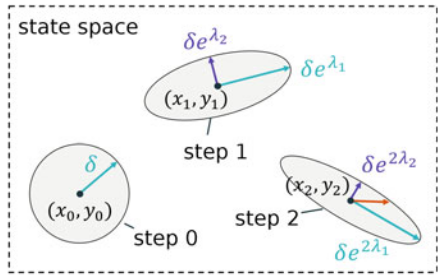
[Source](https://link.springer.com/book/10.1007/978-3-030-91032-7)

- The procedure for computing the Lyapunov spectrum is conceptually similar to the one we described earlier for computing the largest Lyapunov exponent, albeit more complicated.


- To compute the full Lyapunov spectrum of a a dynamical system, use the function `lyapunovspectrum` from DynamicalSystems.jl

In [13]:
# Lyapunov spectrum of the Hénon map we defined earlier
lyapunovspectrum(henon, 1000)

2-element Vector{Float64}:
  0.4642418021303143
 -1.6682146064562504

In [16]:
# Lyapunov spectrum of the Lorenz system we defined earlier
lyapunovspectrum(lorenz, 10000)

3-element Vector{Float64}:
   0.9035842992000886
   4.886579114917681e-6
 -14.5701739896939

- See how easy it is to compute Lyapunov exponents this way? With just two lines of code we can compute the full Lyapunov spectrum!

In [17]:
ds = Systems.lorenz()
lyapunovspectrum(ds, 10000)

3-element Vector{Float64}:
   0.9034783159659977
  -3.526034386225493e-5
 -14.570027859533289

## 6. Interactive Plotting <a class="anchor" id="plotting"></a>

- DynamicalSystems.jl also provides some great interactive utilities via the package [InteractiveDynamics.jl](https://juliadynamics.github.io/InteractiveDynamics.jl/dev/) for exploring dynamical systems and chaos.

In [ ]:
# Run this in VSCode!
using DynamicalSystems
using InteractiveDynamics
using OrdinaryDiffEq
using GLMakie

lorenz = Systems.lorenz()

param_ranges = Dict(
    1 => 1:0.1:30,
    2 => 0:0.1:50,
    3 => 1:0.01:10.0,
)
param_names = Dict(1 => "σ", 2 => "ρ", 3 => "β")

diffeq = (alg = Tsit5(), adaptive = false, dt = 0.01)

interactive_evolution(lorenz, [rand(3), rand(3)], ps = param_ranges, diffeq = diffeq, pnames = param_names)

In [ ]:
# Run this in VSCode!
using DynamicalSystems
using InteractiveDynamics
using OrdinaryDiffEq
using GLMakie

henon = Systems.henon()

i = 1                    # First variable
p_index = 1              # First parameter
p_min, p_max = 0.8, 1.4  # Min,max value of parameter

title = "Orbit Diagram for the Hénon map"

interactive_orbitdiagram(henon, p_index, p_min, p_max, i, parname = "a", title = t)

## 7. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/)
2. [Nonlinear Dynamics: A Concise Introduction Interlaced with Code (Datseris & Parlitz 2022)](https://link.springer.com/book/10.1007/978-3-030-91032-7)

## 8. Next Week <a class="anchor" id="next-week"></a>

1. Data-driven analysis using DynamicalSystems.jl.